<a href="https://colab.research.google.com/github/pulavartivinay/Face_Mask_Detection/blob/API/completeModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
#start

In [10]:
!pip install retinaface_pytorch &> /dev/null

In [11]:
import os
import random
import cv2 
from retinaface.pre_trained_models import get_model
from retinaface.utils import vis_annotations
from google.colab.patches import cv2_imshow
import glob
import itertools
import tensorflow as tf
from keras.utils import plot_model
from keras.models import model_from_json
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

In [12]:
!gdown --id 1mNZ5eaoT9A0LdXLFZcE4lFeM9X6X7Cjt #loading the dataset from google drive link to colab
!unzip /content/rwmfd.zip &> /dev/null #unzipping
!rm -rf /content/rwmfd.zip &> /dev/null #deleting the zip file
!rm -rf __MACOSX &> /dev/null

Downloading...
From: https://drive.google.com/uc?id=1mNZ5eaoT9A0LdXLFZcE4lFeM9X6X7Cjt
To: /content/rwmfd.zip
157MB [00:00, 252MB/s]


In [13]:
def generate_image_paths(dir_path):
  files_jpg = glob.glob(dir_path + '/**/*.jpg', recursive=True)
  files_jpeg = glob.glob(dir_path + '/**/*.jpeg', recursive=True)
  files_png = glob.glob(dir_path + '/**/*.png', recursive=True)
  files_webp = glob.glob(dir_path + '/**/*.webp', recursive=True)
  files_jfif = glob.glob(dir_path + '/**/*.jfif', recursive=True)
  paths = list(itertools.chain(files_jpg, files_jpeg, files_png, files_webp, files_jfif))
  return paths

dataset_path = "/content/rwmfd"
paths = generate_image_paths(dataset_path)

print(len(paths))

4194


In [14]:
def retinaFace_detector(image_path, detector):
  image = cv2.imread(image_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #detector accepts only RGB images
  faces = detector.predict_jsons(image)
  return faces

def openCV_image_cropping(image_path, face):
  img = cv2.imread(image_path)
  crop_img = img[face[1]:face[3], face[0]:face[2]]
  return crop_img

In [15]:
# Complete Model 

class CModel:
  def __init__(self, file_path):
    self.model = self.read_model_from_file(file_path)

  def predict_single(self, image):
    image = cv2.resize(image, (153, 153), interpolation=cv2.INTER_LINEAR)
    input_arr = tf.keras.preprocessing.image.img_to_array(image)
    input_arr = np.array([input_arr])
    p = self.model.predict(input_arr, verbose = 0)
    return round(p[0][0])

  def read_model_from_file(self, file_path):
    json_file = open(file_path, "r")
    model = model_from_json(json_file.read())
    json_file.close()
    model.summary()
    return model
  
  def read_weights_from_file(self, file_path):
    self.model.load_weights(file_path)

In [17]:
cmodel = CModel("/content/model0.json")

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 153, 153, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 150, 150, 2)       98        
_________________________________________________________________
flatten (Flatten)            (None, 45000)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 45001     
Total params: 45,099
Trainable params: 45,099
Non-trainable params: 0
_________________________________________________________________


In [19]:
cmodel.read_weights_from_file("/content/weights_model0.h5")

In [20]:
# loading face detector

detector = get_model("resnet50_2020-07-20", max_size=2048) #value of max_size ?? predition time depends on this
detector.eval()

Downloading: "https://github.com/ternaus/retinaface/releases/download/0.01/retinaface_resnet50_2020-07-20-f168fae3c.zip" to /root/.cache/torch/hub/checkpoints/retinaface_resnet50_2020-07-20-f168fae3c.zip


/usr/local/lib/python3.7/dist-packages/torch/hub.py:483: UserWarning: Falling back to the old format < 1.6. This support will be deprecated in favor of default zipfile format introduced in 1.6. Please redo torch.save() to save it in the new zipfile format.
  warnings.warn('Falling back to the old format < 1.6. This support will be '


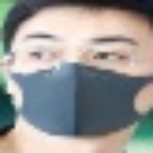

prediction 1


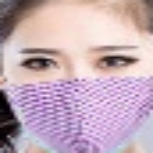

prediction 1


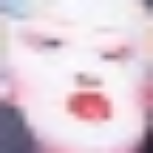

prediction 0


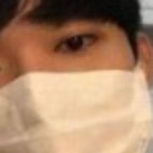

prediction 0


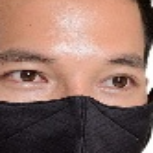

prediction 0


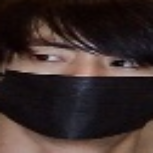

prediction 0


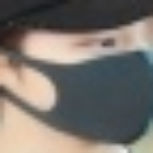

prediction 0


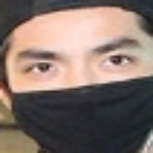

prediction 0


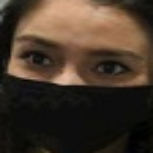

prediction 1


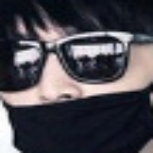

prediction 0


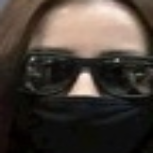

prediction 1


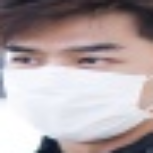

prediction 0


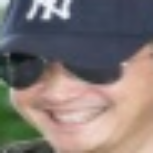

prediction 0


In [21]:
# resizing using linear interpolation
# https://stackoverflow.com/questions/23853632/which-kind-of-interpolation-best-for-resizing-image

random.shuffle(paths)

# size set to 10 random images, make sure to change this while working on problem statement
# detecting - this might take a while
for image_path in paths[:10]:
  faces = retinaFace_detector(image_path, detector)
  for face in faces:
    if face != [] and face["score"] > 0.95:
      cropped_face = openCV_image_cropping(image_path, face["bbox"])
      resized_face = cv2.resize(cropped_face, (153, 153), interpolation=cv2.INTER_LINEAR)
      cv2_imshow(resized_face)
      print("prediction", cmodel.predict_single(resized_face))